# Tracking
First we import the necessary tools:

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import imutils
import scipy
import time

plt.gray()

<Figure size 432x288 with 0 Axes>

Create the stereo class to change any image from 2D to 3D

In [74]:
class Stereo ():
    """
    Class that calculates the disparity of a stereo camera and keeps it so 
    any wanted image can be transformed to 3D. 
    """
    def __init__(self, leftFilename, rightFilename):
        """
        Method to instantiate the class.
            * Input:
            - 
        """
        self.leftFilename = leftFilename
        self.rightFilename = rightFilename
        self.disp = 0
        self.calculateDisparity()
    
    def calculateDisparity (self):
        # Get the images
        leftImg = cv2.imread(leftFilename)
        rightImg = cv2.imread(rightFilename)
        
        # Resize images
        imgSize = (int(leftImg.shape[1]/5), int(leftImg.shape[0]/5))
        leftImg = cv2.resize(leftImg, imgSize, interpolation=cv2.INTER_AREA)
        rightImg = cv2.resize(rightImg, imgSize, interpolation=cv2.INTER_AREA)
        
        # Convert images to grayscale for template matching
        leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
        rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
        
        # Define parameters
        minDisp = 20
        numDisp = 3 * 16
        blockSize = 5
        stereo = cv2.StereoBM_create(numDisparities=numDisp, blockSize = blockSize)
        stereo.setMinDisparity(minDisp)
        stereo.setDisp12MaxDiff(200)
        stereo.setUniquenessRatio(1)
        stereo.setSpeckleRange(3)
        stereo.setSpeckleWindowSize(3)
        
        min_disp = 100
        num_disp = 128 - min_disp
        window_size = 17
        stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = window_size)
        stereo.setMinDisparity(min_disp)
        stereo.setNumDisparities(num_disp)
        stereo.setBlockSize(window_size)
        stereo.setDisp12MaxDiff(0)
        stereo.setUniquenessRatio(10)
        stereo.setSpeckleRange(32)
        stereo.setSpeckleWindowSize(100)
        
        window_size = 3
        min_disp = 3*16
        num_disp = 112-min_disp
        stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
            numDisparities = num_disp,
            blockSize = 16,
            P1 = 8*3*window_size**2,
            P2 = 32*3*window_size**2,
            disp12MaxDiff = 1,
            uniquenessRatio = 10,
            speckleWindowSize = 100,
            speckleRange = 32
        )
        
        disp = stereo.compute(leftGray, rightGray).astype(np.float32) / 16.0
        
        plt.figure(figsize=(18, 18))
        plt.imshow(disp)
        
    
    def get3DImg(self):
        pass

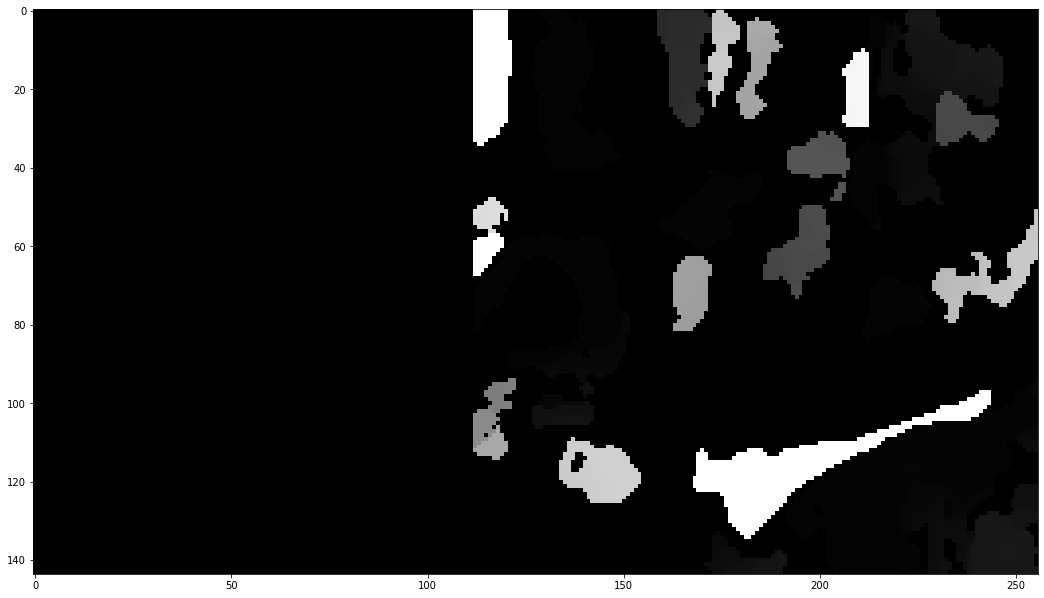

In [75]:
# Read the images in this directory
rightFilename = "undistortedImagesWithoutOcclusion/1585434279_805531979_Right.png"
leftFilename = rightFilename.replace("Right", "Left")
rightImagesGlob = glob.glob("undistortedImagesWithoutOcclusion/*Right.png")
assert rightImagesGlob

stereoObj = Stereo(rightFilename, leftFilename)

# for rightFilename in rightImagesGlob:
#     # Get the left image from the right image
#     leftFilename = rightFilename.replace("Right", "Left")
#     rightImg = cv2.imread(rightFilename)
#     leftImg = cv2.imread(leftFilename)
# #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [76]:
# Read the images in this directory
rightImagesGlob = glob.glob("undistortedImagesWithoutOcclusion/*Right.png")
rightImagesGlob = sorted(rightImagesGlob)

firstFrame = []
for rightFilename in rightImagesGlob:
    if firstFrame == []:  
        rightImg = cv2.imread(rightFilename)
        rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
        rightGray = cv2.GaussianBlur(rightGray, (21, 21), 0)
        firstFrame = rightGray
        continue
    
    rightImg = cv2.imread(rightFilename)
    rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
    rightGray = cv2.GaussianBlur(rightGray, (21, 21), 0)
    
    # compute the absolute difference between the current frame and
    # first frame
    frameDelta = cv2.absdiff(firstFrame, rightGray)
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 4000:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.circle(rightImg, (int(x + w/2), int(y + h/2)), 10, (0, 0, 255), 2)
        cv2.rectangle(rightImg, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    cv2.imshow("Tracking", rightImg)
    
    key = cv2.waitKey(10) & 0xFF
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break
    
#     firstFrame = rightGray
    
cv2.destroyAllWindows()

/home/carla/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


KeyboardInterrupt: 